# Stable Diffusion

> Fill in a module description here

In [ ]:
#| default_exp stable_diffusion

In [ ]:
#| hide
from nbdev.showdoc import *
import nbdev; nbdev.nbdev_export()

/Users/education/miniforge3/envs/sb-from-scratch/lib/python3.9/site-packages/nbdev/export.py:54: UserWarning: Notebook '/Users/education/DATA/projects/ai/stable-diffusion-from-scratch/nbs/stable.ipynb' uses `#|export` without `#|default_exp` cell.
Note nbdev2 no longer supports nbdev1 syntax. Run `nbdev_migrate` to upgrade.
See https://nbdev.fast.ai/getting_started.html for more information.
  warn(f"Notebook '{nbname}' uses `#|export` without `#|default_exp` cell.\n"


In [ ]:
#| export
from PIL import Image

import torch
from tqdm import tqdm


from foundation.autoencoder.autoencoder_kl import AutoencoderKL
from foundation.clip.tokenizier import CLIPTokenizer
from foundation.clip.text_encoder import CLIPTextEncoder
from foundation.unet.condition_model import UNet2DConditionModel
from foundation.scheduler.lms import LMSDiscreteScheduler

/Users/education/miniforge3/envs/sb-from-scratch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.0.mlp.fc1.weight', 'vision_model.encoder.layers.21.self_attn.k_proj.bias', 'vision_model.post_layernorm.bias', 'vision_model.encoder.layers.12.layer_norm2.bias', 'vision_model.encoder.layers.12.self_attn.k_proj.bias', 'vision_model.encoder.layers.11.self_attn.v_proj.bias', 'vision_model.encoder.layers.0.self_attn.q_proj.weight', 'vision_model.encoder.layers.1.mlp.fc2.weight', 'vision_model.encoder.layers.2.self_attn.k_proj.bias', 'vision_model.encoder.layers.5.mlp.fc2.weight', 'vision_model.encoder.layers.9.self_attn.v_proj.bias', 'vision_model.encoder.layers.1.sel

In [ ]:
class StableDiffusion:
    def __init__(
        self,
        n_inference_steps: int = 30, guidance_scale: float = 7.5,
        seed: int = 42
    ):
        self.tokenizer = CLIPTokenizer()
        self.text_encoder = CLIPTextEncoder()
        self.unet = UNet2DConditionModel()
        self.image_decoder = AutoencoderKL()
        self.scheduler = LMSDiscreteScheduler()
        
        self.n_inference_steps: int = n_inference_steps
        self.guidance_scale: float = guidance_scale
        self.seed: int = seed
        
        self.batch_size = 1
        
        self.height = 512
        self.width = 512
        self.latent_height = 512 // 8
        self.latent_width = 512 // 8
        
        self.scheduler.set_timesteps(self.n_inference_steps)
    
    def create_text_embeddings(self, prompt: str) -> torch.Tensor:
        prompt_tokens = self.tokenizer.encode(prompt)
        max_length = prompt_tokens.input_ids.shape[-1]
        
        uncond_tokens = self.tokenizer(
            [""] * self.batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
        )
        
        with torch.no_grad():
            prompt_embeddings = self.text_encoder.encode_from_ids(prompt_tokens.input_ids)
            uncond_embeddings = self.text_encoder.encode_from_ids(uncond_tokens.input_ids)
        
        text_embeddings = torch.cat([uncond_embeddings, prompt_embeddings])
        
        return text_embeddings
    
    def generate_random_latent(self) -> torch.Tensor:
        latents = torch.randn((
            self.batch_size, self.unet.in_channels,
            self.latent_height, self.latent_width
        ))
        latents = latents * self.scheduler.init_noise_sigma
        return latents
    
    def forward_diffusion(self, text_embeddings: torch.Tensor, latents: torch.Tensor) -> torch.Tensor:
        with torch.autocast("cuda"):
            for i, t in tqdm(enumerate(self.scheduler.timesteps)):
                # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
                latent_model_input = torch.cat([latents] * 2)
                sigma = self.scheduler.sigmas[i]
                
                # scale the latents (preconditions)
                latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)
                
                # predict the noise residual
                with torch.no_grad():
                    noise_pred = self.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample
                    
                # perform guidance
                noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                noise_pred = noise_pred_uncond + self.guidance_scale * (noise_pred_text - noise_pred_uncond)

                # compute the previous noisy sample x_t -> x_t-1
                # latents = scheduler.step(noise_pred, i, latents)["prev_sample"] # Diffusers 0.3 and below
                latents = self.scheduler.step(noise_pred, t, latents).prev_sample
                
        return latents
        
    def decode_latents(self, latents: torch.tensor):
        latents = 1 / 0.18215 * latents
        with torch.no_grad():
            image = self.image_decoder.decode(latents).sample
        
        return image

    def decode_images_from_vae(self, image: torch.Tensor):
        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
        images = (image * 255).round().astype("uint8")
        
        return images
        
    def generate(self, prompt: str):        
        text_embeddings = self.create_text_embeddings(prompt)
        latents = self.generate_random_latent()
        latents = self.forward_diffusion(text_embeddings, latents)
        images = self.decode_latents(latents)
        images = self.decode_images_from_vae(images)
        
        return images

In [ ]:
model = StableDiffusion(n_inference_steps=30)
images = model.generate(prompt="Chibi spiderman, octane rendering, modern Disney style")

30it [04:15,  8.53s/it]


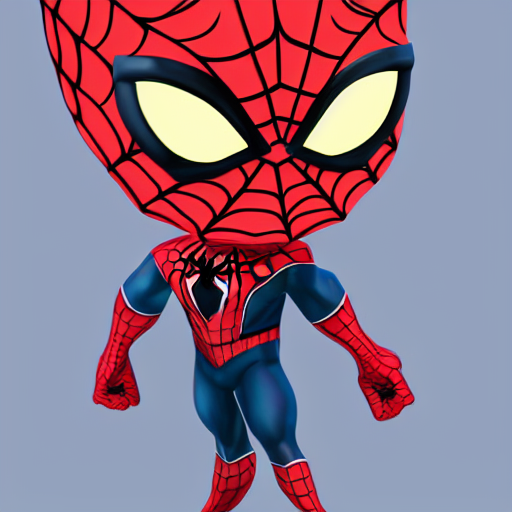

In [ ]:
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]

In [ ]:
from tqdm import tqdm
for i in tqdm(range(10000)):
    pass

100%|██████████| 10000/10000 [00:00<00:00, 7147757.33it/s]
